# Visualization of eigenstates (for $J=0$ and $\lambda < 0$).
Reads in a list of eigenstates (stored via the numpy.save routine) and visualizes them.

In [510]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../python_gauss_lattice/')
from gauss_lattice import HamiltonianBuilder
from gauss_lattice.aux import size_tag, read_all_states
data_dir = '../python_gauss_lattice/output/'

param = {
    'L' : [2,2,2],
    'lambda' : -5,
    'gauge_particles' : 'bosons'
}
tag = '_' + param['gauge_particles'] + '_' + size_tag(param['L']) + '_lam{:.2f}.dat'.format(param['lambda'])
eigenvalues = pd.read_csv(data_dir + 'spectrum'+tag, skiprows=0, names=['E'], index_col=False)
eigenstates = np.load(data_dir+'eigenstates'+tag+'.npy')


lattices = np.array(read_all_states(param['L'], basedir='../python_gauss_lattice/'))
builder = HamiltonianBuilder(param, states=lattices)

Setting up the Hamiltonian with 9600 Fock states.


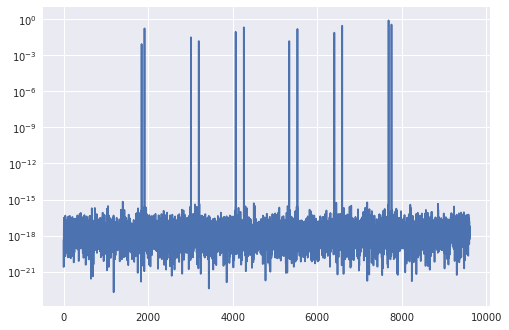

In [497]:
estate = 0

with plt.style.context('seaborn'):
    fig, ax = plt.subplots()
    
    ax.plot(np.abs(eigenstates[:,estate]))
    
    ax.set_yscale('log')
    
threshold = 1e-10
contributions = np.array(builder.lookup_table)[np.argwhere(np.abs(eigenstates[:,estate]) >= threshold).flatten()]

# of flippable plaquettes: 4


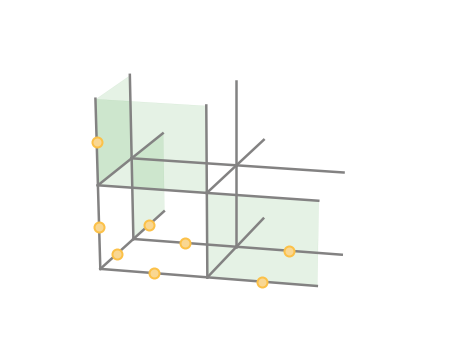

In [611]:
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

def get_vertex_links(b, a):
    """ Takes coordinates and returns the links to a vertex.
    """
    return [(*b[:k], b[k]+a,*b[k+1:]) for k in range(len(b))]

def particle_coordinates(link, a=2, L=[2,2,2]):
    """ Maps a link to the coordinates on the plot. Returns start and endpoint.
    """
    s = link // len(L)
    d = link % len(L)
    
    base = [
        a * (s % L[0]),
        a * ((s // L[0]) % L[1]),
        a * ((s // (L[0]*L[1])) % L[2])
    ]
    l = list(get_vertex_links(base, a)[d])
    l[d] -= a/2
    return l

def link_coordinates(link, a=2, L=[2,2,2]):
    """ Maps a link to the coordinates on the plot. Returns start and endpoint.
    """
    s = link // len(L)
    d = link % len(L)
    
    base = [
        a * (s % L[0]),
        a * ((s // L[0]) % L[1]),
        a * ((s // (L[0]*L[1])) % L[2])
    ]
    l = get_vertex_links(base, a)
    return base, l[d]

def draw_3D_lattice(ax, L=[2,2,2], a=2.0, pbc=True):
    all_links = []
    for z in range(L[0]):
        for y in range(L[1]):
            for x in range(L[2]):
                links = get_vertex_links([x*a, y*a, z*a], a)
                for l in links:
                    all_links.append([[x*a, l[0]], [y*a, l[1]], [z*a, l[2]]])
                    if (len(all_links)-1) == 100:
                        ax.plot(*all_links[-1], color='red')
                    else:
                        ax.plot(*all_links[-1], 
                                color='#838282',
                                lw=2.5,
                                zorder=10-a*y
                        )
        
    return all_links

def draw_particle(ax, pos, links, a=2.0, colors=['#FCC148', '#F9D792']):
    coord = list(map(lambda x: [x[0]], links[pos]))
    coord[pos%len(links[0])][0] += a/2
    ax.plot(xs=coord[0], ys=coord[1], zs=coord[2], 
            marker='o', 
            markeredgecolor=colors[0], 
            markerfacecolor=colors[1], 
            markersize=10,
            markeredgewidth=2,
            zorder=10-a*(coord[1][0]//a)+1
    )


def draw_state(ax, state, n_basis=24, colors=['#FCC148', '#F9D792']):
    for k in range(n_basis):
        if (state>>k)&1: 
            draw_particle(ax, k, links, colors=colors)
    
def highlight_plaquette(ax, p, color='gray', alpha=0.2, a=2):
    lcs = [link_coordinates(v) for v in p]

    base = lcs[0][0]
    shift_1 = np.array(lcs[0][1]) - np.array(lcs[0][0])
    shift_2 = np.array(lcs[1][1]) - np.array(lcs[1][0])
    shift_3 = np.array(lcs[2][1]) - np.array(lcs[2][0])
    pts = np.array([
        base,
        base + shift_1,
        base + shift_1 + shift_2,
        base - shift_1 + shift_2 + shift_3
    ])
    tri = a3.art3d.Poly3DCollection([pts], alpha=alpha, color=color)
    ax.add_collection3d(tri)

def find_flippable_plaquettes(state, builder):
    """ Finds the flippable plaquettes and returns them.
    """
    pflips = []
    for p in builder.plaquettes:
        if builder.apply_u_dagger(state, p)[0] or builder.apply_u(state, p)[0]:
            pflips.append(p)
    return pflips
                    
def draw_system(state, L=[2,2,2], a=2):
    with plt.style.context('seaborn-notebook'):
        fig = plt.figure()
        fig.set_size_inches(8,6)

        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev=20, azim=-75)
        ax.set_axis_off()

        # Draw the actual system.
        links = draw_3D_lattice(ax)
        points = draw_state(ax, state)

        # Get flippable plaquettes & color them.
        pflip = find_flippable_plaquettes(state, builder)
        print(f'# of flippable plaquettes: {len(pflip)}')
        for p in builder.plaquettes:
            if p in pflip:
#                 pass
                highlight_plaquette(ax, p[:-1], color='green', alpha=0.1)
#             else:
#                 highlight_plaquette(ax, p[:-1], color='red', alpha=0.1)

    return fig, ax
            
fig, ax = draw_system(builder.index_to_state(26))
# for state in [26, 57, 60, 2114, 934, 186, 26]:
#     draw_system(builder.index_to_state(state))

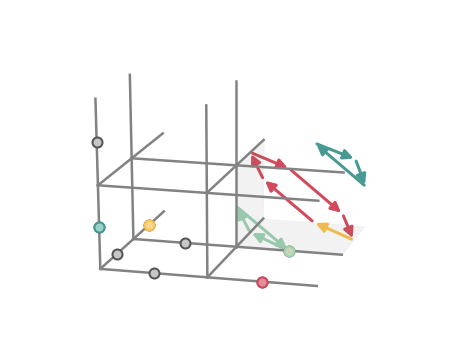

In [626]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

        
def draw_worldline(ax, path, a=2, color='gray'):
    """ Draws a worldline for a specific particle.
    """ 
    pts = []
    for p in path:
        pt = np.array(p[:-1])*a
        d = p[-1]
        l = get_vertex_links(pt, a)[d]
        
        shift = np.zeros(len(pt))
        shift[d] -= a/2
        pts.append(l+shift)
    
    for k in range(len(pts)-1):
        a = Arrow3D(
            [pts[k][0],pts[k+1][0]], 
            [pts[k][1],pts[k+1][1]], 
            [pts[k][2],pts[k+1][2]], 
            mutation_scale=20, lw=3, arrowstyle="-|>", color=color)
        ax.add_artist(a)

with plt.style.context('seaborn-notebook'):
    fig = plt.figure()
    fig.set_size_inches(8,6)

    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=20, azim=-75)
    ax.set_axis_off()

    state = builder.index_to_state(26)
    
    # Draw the actual system.
    links = draw_3D_lattice(ax)
    points = draw_state(ax, state, colors=['#555555', '#c7c7c7'])
    
    
    draw_particle(ax, 7, links, colors=['#FCC148', '#F9D792'])
    draw_worldline(ax, [
        (2,1,0,1),
        (1,2,0,0)
    ], color='#FCC148')
    
    draw_particle(ax, 3, links, colors=['#D1495B', '#E28D98'])
    draw_worldline(ax, [
        (1,2,0,0),
        (1,2,0,2),
        (1,1,1,1),
        (1,1,1,0),
        (2,1,0,2),
        (2,1,0,1)
    ], color='#D1495B')
    
    draw_particle(ax, 9, links, colors=['#9CD2B1', '#C9D5B5'])
    draw_worldline(ax, [
        (1,1,0,0),
        (1,1,0,1),
        (1,1,0,2),
        (1,1,0,0)
    ], color='#9CD2B1')
    
    draw_particle(ax, 2, links, colors=['#479A93', '#9AD2CB'])
    draw_worldline(ax, [
        (2,2,0,2),
        (1,2,1,0),
        (2,1,1,1),
        (2,2,0,2),
    ], color='#479A93')
    
    highlight_plaquette(ax, builder.plaquettes[9], color='gray', alpha=0.1)
    highlight_plaquette(ax, builder.plaquettes[10], color='gray', alpha=0.1)
#     highlight_plaquette(ax, builder.plaquettes[11], color='gray', alpha=0.1)
    
#     draw_worldline(ax, [(2,1,0,0),(1,2,0,1)])

    fig.savefig('wordline_plot.svg')
